In [1]:
import sys, os, json, random
import torch
import sys
import datetime

import cv2

import numpy as np
import pandas as pd

import skimage.io as io

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
%matplotlib inline

from shapely.geometry import Polygon

# path to the images
data_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v3/car-damage-detection/car-damages/File1"

# create paths for traininig and validaiton data
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v3/car-damage-detection/working/data/", exist_ok=True)
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v3/car-damage-detection/working/data/train/", exist_ok=True)
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v3/car-damage-detection/working/data/val/", exist_ok=True)

# create path to store the model config
os.makedirs("C:/Users/kurt_/car-parts-and-damage-detection-v3/car-damage-detection/working/model/", exist_ok=True)

data_working_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v3/car-damage-detection/working/data/"
model_dir = "C:/Users/kurt_/car-parts-and-damage-detection-v3/car-damage-detection/working/model/"

In [2]:
import json
import os
import shutil
import random
from PIL import Image

images_dir = os.path.join(data_dir, "img")
annotations_dir = os.path.join(data_dir, "ann")


# Get list of images
images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

# Shuffle the images
random.shuffle(images)

# Split the dataset (e.g., 80% train, 20% val)
split_index = int(0.8 * len(images))
train_images = images[:split_index]
val_images = images[split_index:]

def convert_to_coco(images, images_dir, annotations_dir, output_dir):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_mapping = {
        "Dent": 1,
        "Scratch": 2,
        "Broken part": 3,
        "Paint chip": 4,
        "Missing part": 5,
        "Flaking": 6,
        "Corrosion": 7,
        "Cracked": 8
    }

    for category, id in category_mapping.items():
        coco_output["categories"].append({
            "id": id,
            "name": category
        })

    annotation_id = 1
    for idx, image_filename in enumerate(images):
        image_path = os.path.join(images_dir, image_filename)
        annotation_path = os.path.join(annotations_dir, image_filename + ".json")
        
        # Copy the image to the output directory
        shutil.copy(image_path, output_dir)
        
        # Open the image to get its dimensions
        with Image.open(image_path) as img:
            width, height = img.size
        
        coco_output["images"].append({
            "file_name": image_filename,
            "height": height,
            "width": width,
            "id": idx
        })
        
        with open(annotation_path) as f:
            objs = json.load(f)["objects"]

        for obj in objs:
            px = [point[0] for point in obj["points"]["exterior"]]
            py = [point[1] for point in obj["points"]["exterior"]]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            category_id = category_mapping.get(obj["classTitle"], -1)
            if category_id == -1:
                continue  # Skip unknown categories
            
            bbox = [min(px), min(py), max(px) - min(px), max(py) - min(py)]
            
            coco_output["annotations"].append({
                "bbox": bbox,
                "category_id": category_id,
                "image_id": idx,
                "segmentation": [poly],
                "area": bbox[2] * bbox[3],
                "iscrowd": 0,
                "id": annotation_id
            })
            annotation_id += 1

    return coco_output

train_output = convert_to_coco(train_images, images_dir, annotations_dir, os.path.join(data_working_dir, "train"))
val_output = convert_to_coco(val_images, images_dir, annotations_dir, os.path.join(data_working_dir, "val"))

with open(os.path.join(data_working_dir, "train", "annotations.json"), "w") as f:
    json.dump(train_output, f, indent=4)

with open(os.path.join(data_working_dir, "val", "annotations.json"), "w") as f:
    json.dump(val_output, f, indent=4)

In [3]:
from detectron2.data.datasets import register_coco_instances

# Register train and val datasets
register_coco_instances("car_train", {}, os.path.join(data_working_dir, "train", "annotations.json"), os.path.join(data_working_dir, "train"))
register_coco_instances("car_val", {}, os.path.join(data_working_dir, "val", "annotations.json"), os.path.join(data_working_dir, "val"))

# Load metadata
from detectron2.data import MetadataCatalog
car_metadata = MetadataCatalog.get("car_train")

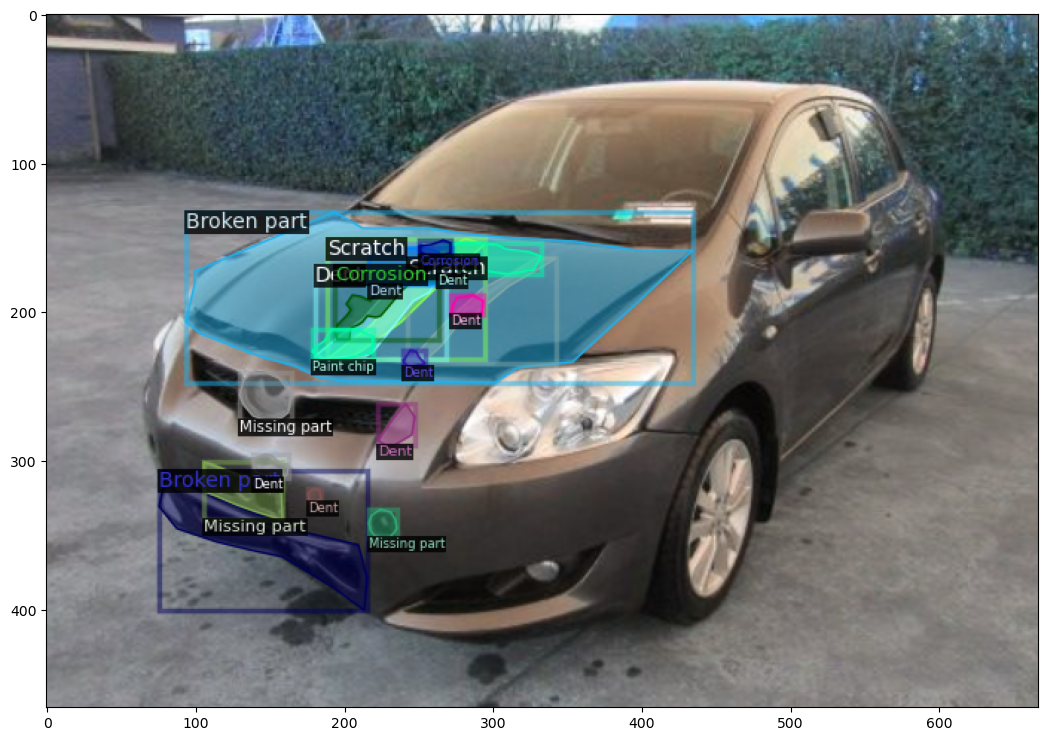

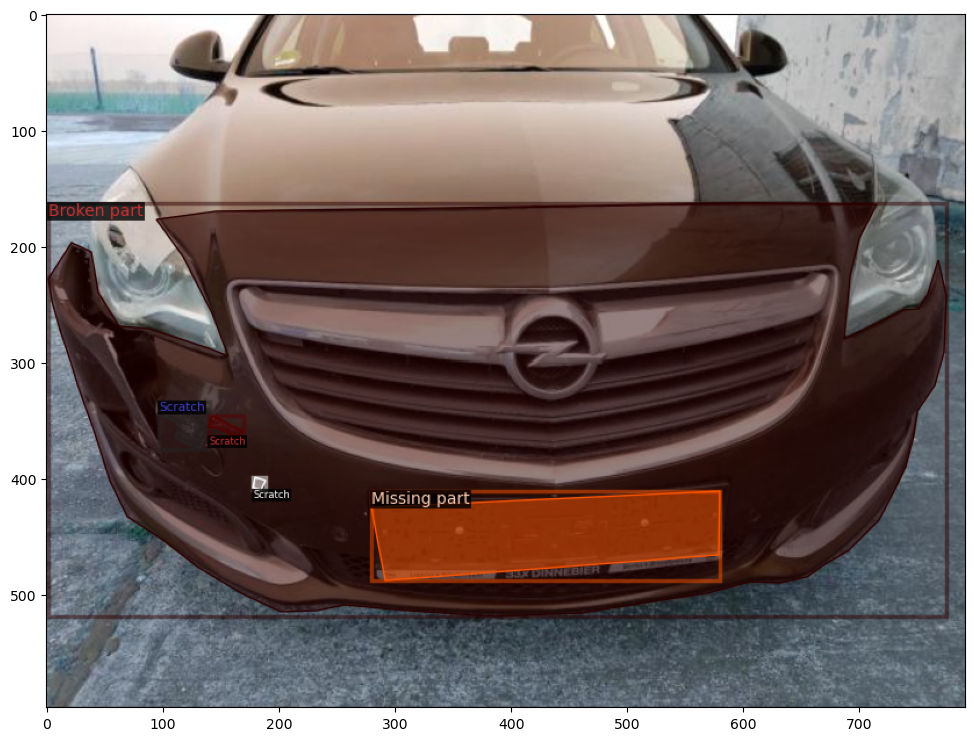

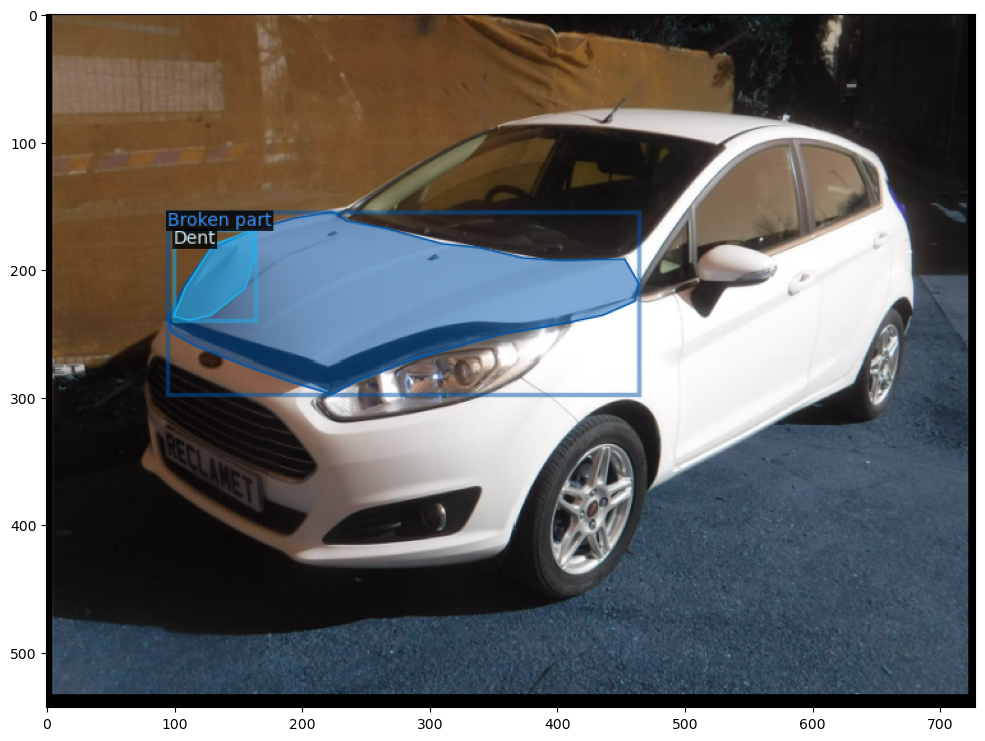

In [4]:
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog

dataset_dicts = DatasetCatalog.get("car_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
import os
import torch
import detectron2
import datetime
from detectron2.engine import DefaultTrainer, hooks, HookBase
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Define output directory
output_dir = "./output_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Create configuration
cfg = get_cfg()

# Set output directory
cfg.OUTPUT_DIR = output_dir

# Merge configuration from the model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"))

# Set training and testing datasets
cfg.DATASETS.TRAIN = ("car_train",)
cfg.DATASETS.TEST = ("car_val",)  # for evaluation during training
cfg.DATALOADER.NUM_WORKERS = 4

# Set device to cuda if available
cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set weights from the model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")  # Let training initialize from model zoo

# Set batch size, learning rate, and maximum iterations
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000 
cfg.SOLVER.STEPS = []  # do not decay learning rate

# Set batch size per image and number of classes
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16   # before 8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # total number of classes

# Create output directory if it does not exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom Trainer to add hooks for status updates
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(0, PrintTrainingStatus())
        return hooks

# Custom hook to print training status
class PrintTrainingStatus(HookBase):
    def after_step(self):
        # Print training status every 100 iterations
        if self.trainer.iter % 500 == 0 or self.trainer.iter == self.trainer.max_iter:
            print(f"Iteration {self.trainer.iter}/{self.trainer.max_iter} - Loss: {self.trainer.storage.latest()['total_loss']}")

# Create a trainer
trainer = MyTrainer(cfg)

# Load the model or resume training
trainer.resume_or_load(resume=False)

# Train the model
trainer.train()

[10/28 04:51:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_a2914c.pkl: 220MB [02:58, 1.24MB/s]                                                                        
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (9, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (32, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.ma

[10/28 04:54:14 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\kurt_\anaconda3\envs\my-env-detectron2\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0/2000 - Loss: (4.801276788115501, 0)
[10/28 05:00:49 d2.utils.events]:  eta: 13:26:22  iter: 19  total_loss: 4.459  loss_cls: 2.303  loss_box_reg: 0.5297  loss_mask: 0.6937  loss_rpn_cls: 0.894  loss_rpn_loc: 0.1228    time: 18.8902  last_time: 5.9922  data_time: 0.1780  last_data_time: 0.0048   lr: 4.9953e-06  max_mem: 6097M
[10/28 05:05:45 d2.utils.events]:  eta: 7:09:08  iter: 39  total_loss: 4.286  loss_cls: 2.14  loss_box_reg: 0.5822  loss_mask: 0.6928  loss_rpn_cls: 0.7893  loss_rpn_loc: 0.1283    time: 16.7364  last_time: 26.0031  data_time: 0.0088  last_data_time: 0.0144   lr: 9.9902e-06  max_mem: 6097M
[10/28 05:10:45 d2.utils.events]:  eta: 5:54:20  iter: 59  total_loss: 3.9  loss_cls: 1.806  loss_box_reg: 0.5297  loss_mask: 0.6919  loss_rpn_cls: 0.726  loss_rpn_loc: 0.1377    time: 16.1362  last_time: 6.3401  data_time: 0.0064  last_data_time: 0.0045   lr: 1.4985e-05  max_mem: 6097M
[10/28 05:15:29 d2.utils.events]:  eta: 5:26:45  iter: 79  total_loss: 3.559  loss

In [1]:
import json
import pandas as pd

metrics_path = r"C:\Users\kurt_\car-parts-and-damage-detection-v3\car-damage-detection\output_20241028_045114\metrics.json"
metrics_columns = [
    "data_time",
    "eta_seconds",
    "fast_rcnn/cls_accuracy",
    "fast_rcnn/false_negative",
    "fast_rcnn/fg_cls_accuracy",
    "iteration",
    "loss_box_reg",
    "loss_cls",
    "loss_mask",
    "loss_rpn_cls",
    "loss_rpn_loc",
    "lr",
    "mask_rcnn/accuracy",
    "mask_rcnn/false_negative",
    "mask_rcnn/false_positive",
    "rank_data_time",
    "roi_head/num_bg_samples",
    "roi_head/num_fg_samples",
    "rpn/num_neg_anchors",
    "rpn/num_pos_anchors",
    "time",
    "total_loss"
]


data = []
with open(metrics_path, 'r') as f:
    for line in f:
        json_data = json.loads(line)
        filtered_data = {metric: json_data.get(metric, None) for metric in metrics_columns}
        data.append(filtered_data)


In [2]:
df = pd.DataFrame(data)

In [3]:
df

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_mask,loss_rpn_cls,...,mask_rcnn/accuracy,mask_rcnn/false_negative,mask_rcnn/false_positive,rank_data_time,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss
0,0.008509,48382.983693,0.036458,0.000000,0.063406,19,0.529698,2.303481,0.693689,0.894007,...,0.439337,0.511543,0.614581,0.008509,12.0,4.0,217.000000,39.000000,24.435850,4.459075
1,0.006214,25748.369864,0.130208,0.166667,0.083333,39,0.582242,2.140347,0.692822,0.789313,...,0.539435,0.496873,0.431331,0.006214,12.0,4.0,219.583333,36.416667,10.211433,4.286461
2,0.004780,21260.742949,0.671875,0.890152,0.000000,59,0.529673,1.806289,0.691860,0.726033,...,0.578763,0.607918,0.250914,0.004780,12.0,4.0,219.500000,36.500000,7.656384,3.900355
3,0.005953,19605.951264,0.750000,1.000000,0.000000,79,0.566206,1.389440,0.689658,0.838996,...,0.623299,0.667361,0.130945,0.005953,12.0,4.0,214.083333,41.916667,7.680172,3.558991
4,0.004804,20498.919595,0.750000,1.000000,0.000000,99,0.562393,1.192646,0.686464,0.690106,...,0.621705,0.659030,0.098311,0.004804,12.0,4.0,213.916667,42.083333,11.012035,3.254652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.005221,623.164120,0.843750,0.375000,0.479167,1919,0.547425,0.508482,0.350420,0.087427,...,0.848108,0.137966,0.147068,0.005221,12.0,4.0,216.333333,39.666667,8.742569,1.515782
96,0.005178,465.146250,0.828125,0.437500,0.479167,1939,0.543404,0.492678,0.357983,0.095622,...,0.826212,0.176223,0.156680,0.005178,12.0,4.0,210.416667,45.583333,8.573601,1.619699
97,0.005302,310.425486,0.817708,0.500000,0.416667,1959,0.602644,0.529572,0.370046,0.110719,...,0.828975,0.218297,0.155275,0.005302,12.0,4.0,208.833333,47.166667,7.342236,1.745525
98,0.005461,154.825043,0.843750,0.437500,0.458333,1979,0.553568,0.502633,0.350054,0.086141,...,0.834821,0.190493,0.136827,0.005461,12.0,4.0,220.416667,35.583333,6.121839,1.571313


In [4]:
# F1 Skoru Hesaplama
# F1 Skoru = 2 * (Precision * Recall) / (Precision + Recall)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

accuracy = df['mask_rcnn/accuracy']
# FP ve FN değerlerini al
FP = df['mask_rcnn/false_positive']
FN =df['mask_rcnn/false_negative']

# TP hesaplama
TP = df['mask_rcnn/accuracy']

# Precision ve Recall hesaplama
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# F1 Skoru hesaplama
f1_score = 2 * (precision * recall) / (precision + recall)

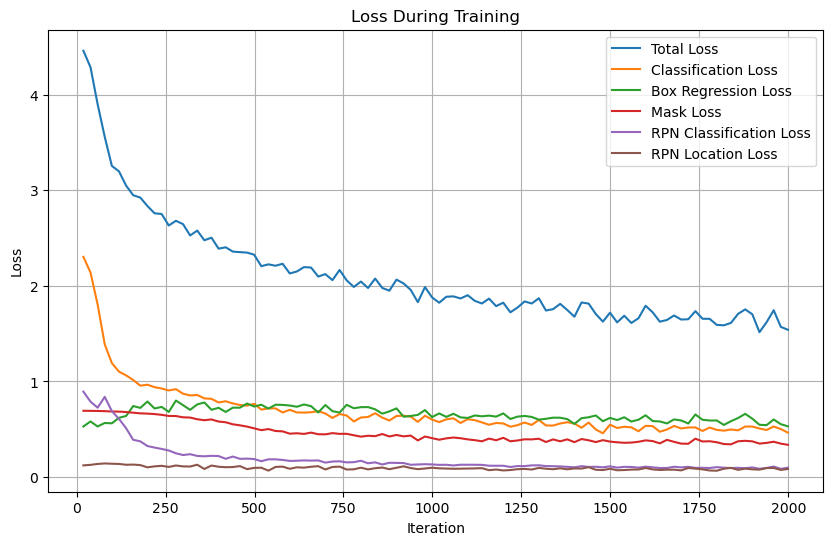

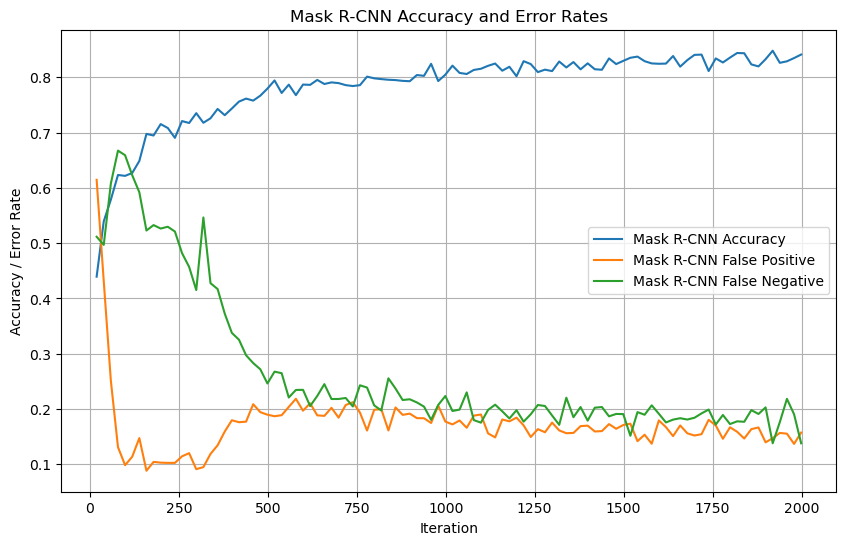

In [5]:
import matplotlib.pyplot as plt
#(Loss) 
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], df['total_loss'], label='Total Loss')
plt.plot(df['iteration'], df['loss_cls'], label='Classification Loss')
plt.plot(df['iteration'], df['loss_box_reg'], label='Box Regression Loss')
plt.plot(df['iteration'], df['loss_mask'], label='Mask Loss')
plt.plot(df['iteration'], df['loss_rpn_cls'], label='RPN Classification Loss')
plt.plot(df['iteration'], df['loss_rpn_loc'], label='RPN Location Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

#  Mask R-CNN Accuracy, False Positive, False Negative 
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], df['mask_rcnn/accuracy'], label='Mask R-CNN Accuracy')
plt.plot(df['iteration'], df['mask_rcnn/false_positive'], label='Mask R-CNN False Positive')
plt.plot(df['iteration'], df['mask_rcnn/false_negative'], label='Mask R-CNN False Negative')
plt.xlabel('Iteration')
plt.ylabel('Accuracy / Error Rate')
plt.title('Mask R-CNN Accuracy and Error Rates')
plt.legend()
plt.grid(True)
plt.show()

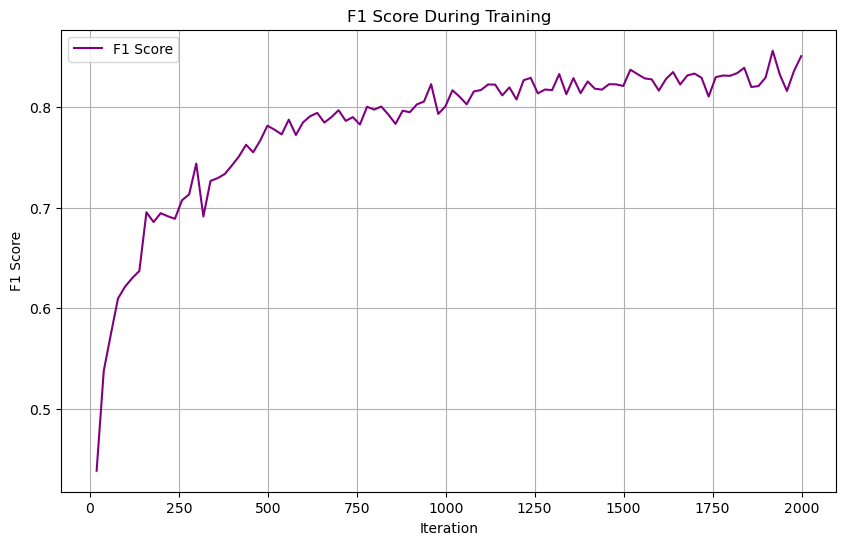

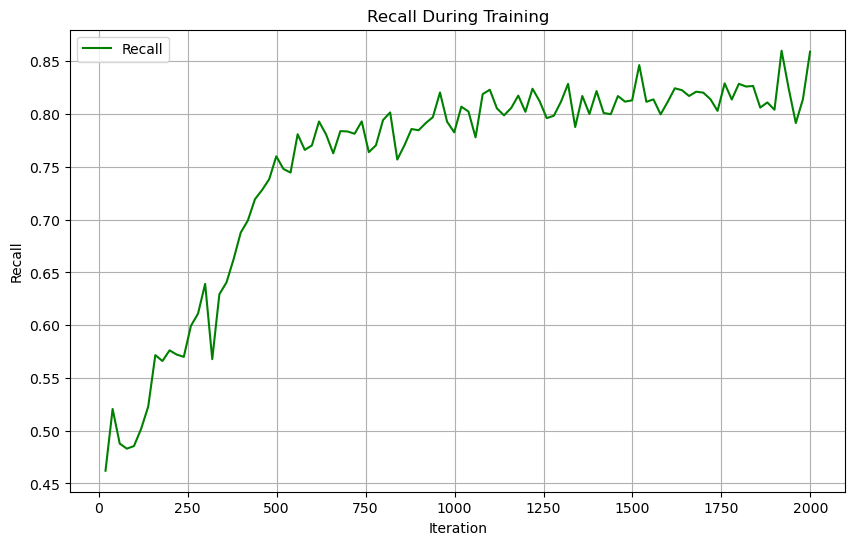

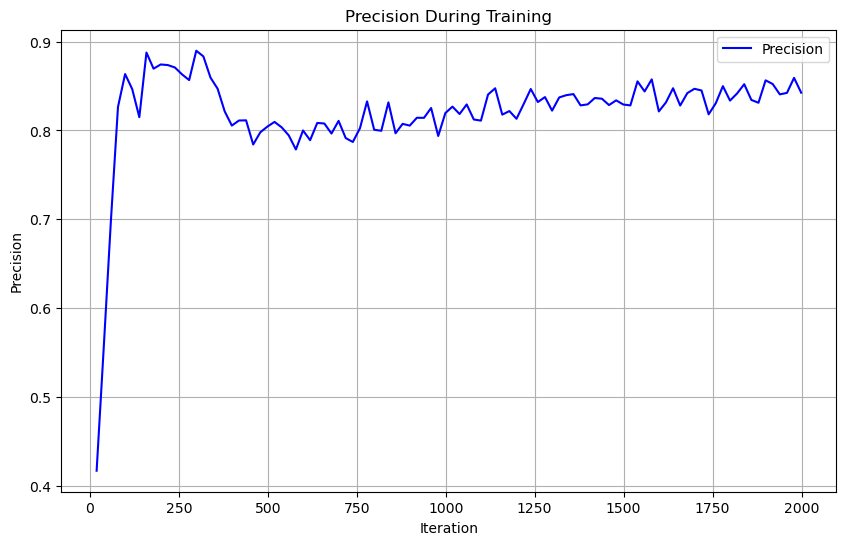

In [6]:
#f1 score
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], f1_score, label='F1 Score', color='purple')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('F1 Score During Training')
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], recall, label='Recall', color='green')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.title('Recall During Training')
plt.legend()
plt.grid(True)
plt.show()

# Precision
plt.figure(figsize=(10, 6))
plt.plot(df['iteration'], precision, label='Precision', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.title('Precision During Training')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
df = df.assign(precision=precision, recall=recall, f1_score=f1_score, accuracy=accuracy)
result_table = df[['iteration', 'precision', 'recall', 'f1_score', 'accuracy']]
result_table

,iteration,precision,recall,f1_score,accuracy
0,19,0.416861,0.462032,0.438286,0.439337
1,39,0.555679,0.520535,0.537534,0.539435
2,59,0.697577,0.487716,0.574068,0.578763
3,79,0.826390,0.482931,0.609612,0.623299
4,99,0.863460,0.485428,0.621472,0.621705
...,...,...,...,...,...
95,1919,0.852219,0.860086,0.856134,0.848108
96,1939,0.840593,0.824205,0.832319,0.826212
97,1959,0.842240,0.791557,0.816112,0.828975
98,1979,0.859180,0.814210,0.836091,0.834821


C:\Users\kurt_\anaconda3\envs\my-env-detectron2\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_loc

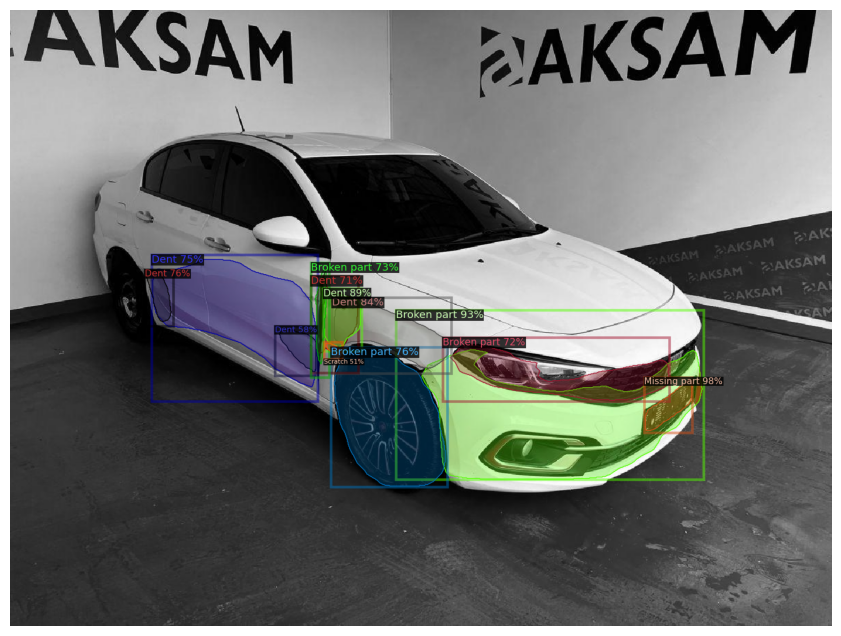

In [16]:
import torch
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog

# Path to your model
model_path = r"C:\Users\kurt_\car-parts-and-damage-detection-v3\car-damage-detection\output_20241028_045114\model_final.pth"

# Category mapping for damage classes
damage_category_mapping = {
    0: "Dent", 1: "Scratch", 2: "Broken part", 3: "Paint chip", 
    4: "Missing part", 5: "Flaking", 6: "Corrosion", 7: "Cracked"
}

# Load and configure the Detectron2 model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"))
cfg.MODEL.WEIGHTS = model_path  # Load your custom weights
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(damage_category_mapping)  # Set the number of classes
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for predictions

# Register the metadata for damage classes
metadata = MetadataCatalog.get("damage_dataset")
metadata.set(thing_classes=list(damage_category_mapping.values()))

# Create a predictor
predictor = DefaultPredictor(cfg)

# Load and preprocess the image
image_path = r"C:\Users\kurt_\Downloads\hasar13.jpg"  # Replace with the path to your test image
image = cv2.imread(image_path)

# Run inference on the image
outputs = predictor(image)

# Use Visualizer to draw bounding boxes and masks with class names
v = Visualizer(
    image[:, :, ::-1],  # Convert BGR to RGB
    metadata=metadata,  # Use the custom metadata with damage labels
    scale=1.2,
    instance_mode=ColorMode.IMAGE_BW  # Change the image to grayscale for better mask visibility
)

# Visualize the predictions with class labels
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the result with Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()
